In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyaldata
import h5py

# %load_ext lab_black

# Set paths

In [2]:
raw_data_dir = (
    "/disk/scratch2/nkudryas/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

# Load the data (one dataset at a time)

In [3]:
perc_train = 80
perc_valid = 20
perc_test = 0
assert perc_train + perc_valid + perc_test == 100

experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat",  # the best!
    "Chewie_CO_VR_2016-09-09.mat",
    "Chewie_CO_VR_2016-09-12.mat",
    "Chewie_CO_VR_2016-09-14.mat",
    "Chewie_CO_VR_2016-10-06.mat",
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
    "Mihili_CO_VR_2014-03-03.mat",
    "Mihili_CO_VR_2014-03-04.mat",
    "Mihili_CO_VR_2014-03-06.mat",
]

activity_key = "M1_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation
full_behaviour_key = "pos"  # extra variable used for validation
alignment = "go"  # align to this point

spike_data_dir = experiments[3]

pd_data = pyaldata.io.mat2dataframe(
    path=raw_data_dir + spike_data_dir, shift_idx_fields=True
)

if activity_key == "all_spikes":
    pd_data[activity_key] = [
        np.concatenate([m1, pmd], axis=1)
        for m1, pmd in zip(pd_data["M1_spikes"], pd_data["PMd_spikes"])
    ]
    print(
        pd_data["M1_spikes"][0].shape,
        pd_data["PMd_spikes"][0].shape,
        pd_data["all_spikes"][0].shape,
    )

In [4]:
pd_data["M1_spikes"][0].shape[-1]

70

In [5]:
print(pd_data.shape, pd_data.loc[0])

(662, 24) monkey                                                          Chewie
date                                                        10-07-2016
task                                                                CO
target_direction                                              0.785398
trial_id                                                             1
result                                                               R
bin_size                                                          0.01
perturbation                                                        FF
perturbation_info                                        [0.15, -1.48]
epoch                                                               BL
idx_trial_start                                                     10
idx_target_on                                                      112
idx_go_cue                                                         231
idx_movement_on                                                    

In [7]:
selected_trials = pd_data.loc[
        (pd_data.result == "R") #& (pd_data.epoch == "AD")
    ]

start_key = 'idx_peak_speed'
shortest_trial = 55
before_go_cue = 100
area = 'M1'

spike_data = np.asarray(
        [
            d[f'{area}_spikes'][d[start_key] - before_go_cue : d[start_key] + shortest_trial, :]
            for i, d in selected_trials.iterrows()
        ]
    )

target_on = np.asarray(
        [
            d[start_key] - d['idx_go_cue']
            for i, d in selected_trials.iterrows()
        ]
    )

epoch = np.asarray(
        [
            d['epoch']
            for i, d in selected_trials.iterrows()
        ]
    )

vel = np.asarray(
        [
            d['vel'][d[start_key] - before_go_cue : d[start_key] + shortest_trial]
            for i, d in selected_trials.iterrows()
        ]
    )

AD_start = np.where(epoch=='AD')[0][0]
WO_start = np.where(epoch=='WO')[0][0]

In [8]:
dataset_type = "session"
if dataset_type == "session":  # all epochs
    successful_trials = pd_data.loc[(pd_data.result == "R")]
elif dataset_type == "BLAD":  # only baseline + adaptation
    successful_trials = pd_data.loc[
        (pd_data.result == "R") & ((pd_data.epoch == "BL") | (pd_data.epoch == "AD"))
    ]
else:
    successful_trials = pd_data.loc[
        (pd_data.result == "R") & (pd_data.epoch == dataset_type)
    ]

longest_trial = None
if alignment == "mov":
    shortest_trial = int(
        (successful_trials.idx_trial_end - successful_trials.idx_movement_on).min()
    )
    start_key = "idx_movement_on"
elif alignment == "go":
    shortest_trial = int(
        (successful_trials.idx_trial_end - successful_trials.idx_go_cue).min()
    )
    longest_trial = int(
        (successful_trials.idx_trial_end - successful_trials.idx_go_cue).max()
    )
    start_key = "idx_go_cue"
elif alignment == "target":
    shortest_trial = int(
        (successful_trials.idx_trial_end - successful_trials.idx_target_on).min()
    )
    start_key = "idx_target_on"
elif alignment == "no":
    shortest_trial = 95
    start_key = "start"
    np.random.seed(42)
    successful_trials[start_key] = np.random.randint(
        successful_trials.idx_trial_start,
        successful_trials.idx_trial_end - shortest_trial,
    )
print(
    f"Shortest : {shortest_trial}, longest: {longest_trial}, succesful trials: {len(successful_trials)}/{len(pd_data)}"
)

Shortest : 101, longest: 150, succesful trials: 581/662


## Split the data into train / valid & (optional)test

In [9]:
n_train = np.round(len(successful_trials) / 100 * perc_train).astype(int)
n_valid = np.round(len(successful_trials) / 100 * perc_valid).astype(int)
if perc_test == 0:
    n_test = n_valid
else:
    n_test = np.round(len(successful_trials) / 100 * perc_test).astype(int)

np.random.seed(42)
order = np.random.permutation(len(successful_trials))
train_df = successful_trials.iloc[order[:n_train]]
if perc_test == 0:
    valid_df = successful_trials.iloc[order[n_train:]]
    test_df = successful_trials.iloc[order[n_train:]]
else:
    valid_df = successful_trials.iloc[order[n_train : (n_train + n_valid)]]
    test_df = successful_trials.iloc[order[(n_train + n_valid) :]]

# train_df.idx_movement_on = train_df.idx_movement_on.astype(int)
# valid_df.idx_movement_on = valid_df.idx_movement_on.astype(int)
# test_df.idx_movement_on = test_df.idx_movement_on.astype(int)

(-9.582353078328099,
 9.067051094616174,
 -39.139231954828226,
 -20.539431707813446)

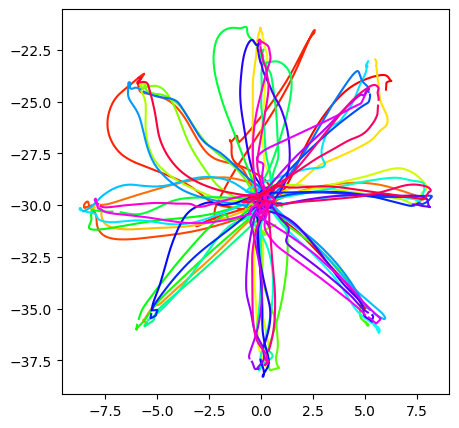

In [10]:
plt.figure(figsize=(5, 5))
n_show = 40
colours = plt.cm.hsv(np.arange(n_show) / n_show)
for i in range(n_show):
    plt.plot(
        successful_trials.iloc[i][full_behaviour_key][:, 0],
        successful_trials.iloc[i][full_behaviour_key][:, 1],
        color=colours[i],
    )
plt.axis("equal")

## Create train/valid/test data (spikes or rates)

In [11]:
if "rates" in activity_key:  # calculate instantaneous firing rates
    w = 10  # width of a gaussian filter
    targets = successful_trials["target_direction"]
    unique_targets = np.unique(targets)
    spike_data = np.asarray(
        [
            d[activity_key[:-5] + "spikes"][
                int(d[start_key]) : int(d[start_key]) + shortest_trial, :
            ]
            for i, d in successful_trials.iterrows()
        ]
    )
    print(spike_data.shape)

    train_spikes = np.asarray(
        [
            d[activity_key[:-5] + "spikes"][
                int(d[start_key]) : int(d[start_key]) + shortest_trial, :
            ]
            for i, d in train_df.iterrows()
        ]
    )
    valid_spikes = np.asarray(
        [
            d[activity_key[:-5] + "spikes"][
                int(d[start_key]) : int(d[start_key]) + shortest_trial, :
            ]
            for i, d in valid_df.iterrows()
        ]
    )
    test_spikes = np.asarray(
        [
            d[activity_key[:-5] + "spikes"][
                int(d[start_key]) : int(d[start_key]) + shortest_trial, :
            ]
            for i, d in test_df.iterrows()
        ]
    )

    def spikes_to_rates(spikes, w=4):
        # kernel
        f = np.linspace(-4 * w, 4 * w, 8 * w - 1)
        K = 1 / (np.sqrt(2 * np.pi) * w) * np.exp(-(f**2) / (2 * w**2))

        data = np.zeros_like(spikes).astype("float")
        for i in range(spikes.shape[0]):
            for j in range(spikes.shape[-1]):
                data[i, :, j] = np.convolve(
                    spikes[i, :, j], K, mode="same"
                )  # (num_trials, len_trial, num_neurons)
        return data

    train_rates = spikes_to_rates(train_spikes, w=w)
    valid_rates = spikes_to_rates(valid_spikes, w=w)
    test_rates = spikes_to_rates(test_spikes, w=w)

    train_data = train_rates
    valid_data = valid_rates
    test_data = test_rates

else:

    train_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
            for i, d in train_df.iterrows()
        ]
    )
    valid_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
            for i, d in valid_df.iterrows()
        ]
    )
    test_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
            for i, d in test_df.iterrows()
        ]
    )

train_data.shape, valid_data.shape, test_data.shape

((465, 101, 70), (116, 101, 70), (116, 101, 70))

## Trial metadata: target angle & epoch (baseline | adaptation | washout)

In [12]:
train_target_direction = np.asarray(
    [d["target_direction"] for i, d in train_df.iterrows()]
)
valid_target_direction = np.asarray(
    [d["target_direction"] for i, d in valid_df.iterrows()]
)
test_target_direction = np.asarray(
    [d["target_direction"] for i, d in test_df.iterrows()]
)

train_trial = np.asarray([d["trial_id"] for i, d in train_df.iterrows()])
valid_trial = np.asarray([d["trial_id"] for i, d in valid_df.iterrows()])
test_trial = np.asarray([d["trial_id"] for i, d in test_df.iterrows()])


def etype(epoch):
    """Enumerates epoch types"""
    if epoch == "BL":
        return 0
    elif epoch == "AD":
        return 1
    elif epoch == "WO":
        return 2
    else:
        return -1


train_epoch = np.asarray([etype(d["epoch"]) for i, d in train_df.iterrows()])
valid_epoch = np.asarray([etype(d["epoch"]) for i, d in valid_df.iterrows()])
test_epoch = np.asarray([etype(d["epoch"]) for i, d in test_df.iterrows()])

## Behavior

In [13]:
train_behaviours = np.asarray(
    [
        d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in train_df.iterrows()
    ]
)
valid_behaviours = np.asarray(
    [
        d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in valid_df.iterrows()
    ]
)
test_behaviours = np.asarray(
    [
        d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in test_df.iterrows()
    ]
)

train_pos = np.asarray(
    [
        d[full_behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in train_df.iterrows()
    ]
)
valid_pos = np.asarray(
    [
        d[full_behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in valid_df.iterrows()
    ]
)
test_pos = np.asarray(
    [
        d[full_behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
        for i, d in test_df.iterrows()
    ]
)

print(train_pos.shape, valid_pos.shape)

origin = train_pos[:, 0].mean(0)
train_pos -= origin
valid_pos -= origin
test_pos -= origin

train_behaviours.shape, valid_behaviours.shape, test_behaviours.shape

(465, 101, 2) (116, 101, 2)


((465, 101, 2), (116, 101, 2), (116, 101, 2))

## Organize all in a dictionary

In [17]:
data_dir = (
    data_save_dir
    + spike_data_dir[:-4]
    + "_"
    + dataset_type
    + "_"
    + behaviour_key
    + "_"
    + activity_key
    + "_"
    + alignment
)

filename = data_dir + f".h5"

with h5py.File(filename, 'w') as h5file:
    # variables needed for training
    h5file.create_dataset('train_encod_data', data=train_data)
    h5file.create_dataset('valid_encod_data', data=valid_data)
    h5file.create_dataset('train_recon_data', data=train_data)
    h5file.create_dataset('valid_recon_data', data=valid_data)
    h5file.create_dataset('train_behavior', data=train_behaviours[:,:])
    h5file.create_dataset('valid_behavior', data=valid_behaviours[:,:])
    # variables needed for post analysis
    h5file.create_dataset('train_inds', data=train_trial)
    h5file.create_dataset('valid_inds', data=valid_trial)
    h5file.create_dataset('train_epoch', data=train_epoch)
    h5file.create_dataset('valid_epoch', data=valid_epoch)
    h5file.create_dataset('train_pos', data=train_pos)
    h5file.create_dataset('valid_pos', data=valid_pos)
    h5file.create_dataset('train_vel', data=train_behaviours)
    h5file.create_dataset('valid_vel', data=valid_behaviours)
    h5file.create_dataset('train_target_direction', data=train_target_direction)
    h5file.create_dataset('valid_target_direction', data=valid_target_direction)

In [18]:
train_data.shape

(465, 101, 70)

In [16]:
# read an h5file /disk/scratch2/nkudryas/BAND-torch/datasets/area2_bump-05ms-val.h5
filename = '/disk/scratch2/nkudryas/BAND-torch/datasets/area2_bump-05ms-val.h5'
# check all keys is h5file
f1 = h5py.File(filename,'r')  

f1.keys()

<KeysViewHDF5 ['psth', 'train_behavior', 'train_cond_idx', 'train_decode_mask', 'train_encod_data', 'train_recon_data', 'valid_behavior', 'valid_cond_idx', 'valid_decode_mask', 'valid_encod_data', 'valid_recon_data']>

## Save the data

In [ ]:
data_dir = (
    data_save_dir
    + spike_data_dir[:-4]
    + "_"
    + dataset_type
    + "_"
    + behaviour_key
    + "_"
    + activity_key
    + "_"
    + alignment
)

In [ ]:
filename = data_dir + f".h5"
print("saving to " + filename)
compression = None
try:
    with h5py.File(filename, "w") as hf:
        for k, v in data_dict.items():
            if type(k) is str:
                clean_k = k.replace("/", "_")
                if clean_k is not k:
                    print("Warning: saving variable with name: ", k, " as ", clean_k)
                else:
                    print("Saving variable with name: ", clean_k)
            else:
                clean_k = k
            hf.create_dataset(clean_k, data=v, compression=compression)
except IOError:
    print("Cannot open %s for writing.", data_fname)

saving to /disk/scratch/nkudryas/band/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_go.h5
Saving variable with name:  train_data
Saving variable with name:  valid_data
Saving variable with name:  test_data
Saving variable with name:  train_behavior
Saving variable with name:  valid_behavior
Saving variable with name:  test_behavior
Saving variable with name:  train_full_behavior
Saving variable with name:  valid_full_behavior
Saving variable with name:  test_full_behavior
Saving variable with name:  train_target_direction
Saving variable with name:  valid_target_direction
Saving variable with name:  test_target_direction
Saving variable with name:  train_inds
Saving variable with name:  valid_inds
Saving variable with name:  test_inds
Saving variable with name:  train_epoch
Saving variable with name:  valid_epoch
Saving variable with name:  test_epoch


# All the same in a loop

In [ ]:
trial_dur = 82 # set trial duration (number of bins)
perc_train = 80
perc_valid = 20
perc_test = 0
assert perc_train + perc_valid + perc_test == 100
alignment = "go"

def etype(epoch):
    if epoch == "BL":
        return 0
    elif epoch == "AD":
        return 1
    elif epoch == "WO":
        return 2
    else:
        return -1

for experiment in experiments:
    spike_data_dir = experiment
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir +spike_data_dir,
        shift_idx_fields=True,
    )
    print(spike_data_dir)
    for activity_key in ["all_spikes"]:  # ,'M1_spikes','PMd_spikes']:
        if activity_key == "all_spikes":
            pd_data[activity_key] = [
                np.concatenate([m1, pmd], axis=1)
                for m1, pmd in zip(pd_data["M1_spikes"], pd_data["PMd_spikes"])
            ]
        for behaviour_key in ["vel"]:  # ['pos', 'vel', 'acc','force']:
            data_dir = (
                data_save_dir
                + spike_data_dir[:-4]
                + "_"
                + dataset_type
                + "_"
                + behaviour_key
                + "_"
                + full_behaviour_key
                + "_"
                + activity_key
                + "_"
                + alignment
            )
            if not os.path.exists(data_dir):
                os.makedirs(data_dir)

            dataset_type = "session"
            if dataset_type == "session":  # all epochs
                successful_trials = pd_data.loc[(pd_data.result == "R")]
            elif (
                (dataset_type == "BLAD")
            ):
                successful_trials = pd_data.loc[
                    (pd_data.result == "R")
                    & ((pd_data.epoch == "BL") | (pd_data.epoch == "AD"))
                ]
            else:
                successful_trials = pd_data.loc[
                    (pd_data.result == "R") & (pd_data.epoch == dataset_type)
                ]
           
            longest_trial = None
            if alignment == "mov":
                shortest_trial = int(
                    (
                        successful_trials.idx_trial_end
                        - successful_trials.idx_movement_on
                    ).min()
                )
                start_key = "idx_movement_on"
            elif alignment == "go":
                shortest_trial = int(
                    (successful_trials.idx_trial_end - successful_trials.idx_go_cue).min()
                )
                longest_trial = int(
                    (successful_trials.idx_trial_end - successful_trials.idx_go_cue).max()
                )
                start_key = "idx_go_cue"
            elif alignment == "target":
                shortest_trial = int(
                    (
                        successful_trials.idx_trial_end - successful_trials.idx_target_on
                    ).min()
                )
                start_key = "idx_target_on"
            elif alignment == "no":
                shortest_trial = 95
                start_key = "start"
                np.random.seed(42)
                successful_trials[start_key] = np.random.randint(
                    successful_trials.idx_trial_start,
                    successful_trials.idx_trial_end - shortest_trial,
                )
            print(
                f"Shortest : {shortest_trial}, longest: {longest_trial}, succesful trials: {len(successful_trials)}/{len(pd_data)}"
            )
            shortest_trial = trial_dur  # overwrite

            n_train = np.round(len(successful_trials) / 100 * perc_train).astype(int)
            n_valid = np.round(len(successful_trials) / 100 * perc_valid).astype(int)
            
            np.random.seed(42)
            order = np.random.permutation(len(successful_trials))            
            train_df = successful_trials.iloc[order[:n_train]]
            if perc_test == 0:
                valid_df = successful_trials.iloc[order[n_train:]]
                test_df = successful_trials.iloc[order[n_train:]]
            else:
                valid_df = successful_trials.iloc[order[n_train : (n_train + n_valid)]]
                test_df = successful_trials.iloc[order[(n_train + n_valid) :]]


            train_df.idx_movement_on = train_df.idx_movement_on.astype(int)
            valid_df.idx_movement_on = valid_df.idx_movement_on.astype(int)
            test_df.idx_movement_on = test_df.idx_movement_on.astype(int)

            train_data = np.asarray(
                [
                    d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in train_df.iterrows()
                ]
            )
            valid_data = np.asarray(
                [
                    d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in valid_df.iterrows()
                ]
            )
            test_data = np.asarray(
                [
                    d[activity_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in test_df.iterrows()
                ]
            )

            print(train_data.shape, valid_data.shape)

            train_target_direction = np.asarray(
                [d["target_direction"] for i, d in train_df.iterrows()]
            )
            valid_target_direction = np.asarray(
                [d["target_direction"] for i, d in valid_df.iterrows()]
            )
            test_target_direction = np.asarray(
                [d["target_direction"] for i, d in test_df.iterrows()]
            )

            train_trial = np.asarray([d["trial_id"] for i, d in train_df.iterrows()])
            valid_trial = np.asarray([d["trial_id"] for i, d in valid_df.iterrows()])
            test_trial = np.asarray([d["trial_id"] for i, d in test_df.iterrows()])

            train_behaviours = np.asarray(
                [
                    d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in train_df.iterrows()
                ]
            )
            valid_behaviours = np.asarray(
                [
                    d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in valid_df.iterrows()
                ]
            )
            test_behaviours = np.asarray(
                [
                    d[behaviour_key][d[start_key] : d[start_key] + shortest_trial, :]
                    for i, d in test_df.iterrows()
                ]
            )

            train_pos = np.asarray(
                [
                    d[full_behaviour_key][
                        d[start_key] : d[start_key] + shortest_trial, :
                    ]
                    for i, d in train_df.iterrows()
                ]
            )
            valid_pos = np.asarray(
                [
                    d[full_behaviour_key][
                        d[start_key] : d[start_key] + shortest_trial, :
                    ]
                    for i, d in valid_df.iterrows()
                ]
            )
            test_pos = np.asarray(
                [
                    d[full_behaviour_key][
                        d[start_key] : d[start_key] + shortest_trial, :
                    ]
                    for i, d in test_df.iterrows()
                ]
            )

            origin = train_pos[:, 0].mean(0)
            train_pos -= origin
            valid_pos -= origin
            test_pos -= origin

            train_epoch = np.asarray(
                [etype(d["epoch"]) for i, d in train_df.iterrows()]
            )
            valid_epoch = np.asarray(
                [etype(d["epoch"]) for i, d in valid_df.iterrows()]
            )
            test_epoch = np.asarray([etype(d["epoch"]) for i, d in test_df.iterrows()])

            data_dict = dict()
            data_dict["train_data"] = train_data.astype(int)
            data_dict["valid_data"] = valid_data.astype(int)
            data_dict["test_data"] = test_data.astype(int)
            data_dict["train_rates"] = train_data.astype(int)  # do smoothing
            data_dict["valid_rates"] = valid_data.astype(int)
            data_dict["test_rates"] = test_data.astype(int)
            data_dict["train_behavior"] = train_behaviours.astype(float)
            data_dict["valid_behavior"] = valid_behaviours.astype(float)
            data_dict["test_behavior"] = test_behaviours.astype(float)
            data_dict["train_full_behavior"] = train_pos.astype(float)
            data_dict["valid_full_behavior"] = valid_pos.astype(float)
            data_dict["test_full_behavior"] = test_pos.astype(float)
            data_dict["train_target_direction"] = train_target_direction.astype(float)
            data_dict["valid_target_direction"] = valid_target_direction.astype(float)
            data_dict["test_target_direction"] = test_target_direction.astype(float)
            data_dict["train_trial"] = train_trial.astype(int)
            data_dict["valid_trial"] = valid_trial.astype(int)
            data_dict["test_trial"] = test_trial.astype(int)
            data_dict["train_epoch"] = train_epoch.astype(int)
            data_dict["valid_epoch"] = valid_epoch.astype(int)
            data_dict["test_epoch"] = test_epoch.astype(int)

            print("saving to " + data_dir + f"/neural_{dataset_type}.h5")
            compression = None
            try:
                with h5py.File(data_dir + f"/neural_{dataset_type}.h5", "w") as hf:
                    for k, v in data_dict.items():
                        if type(k) is str:
                            clean_k = k.replace("/", "_")
                            if clean_k is not k:
                                print(
                                    "Warning: saving variable with name: ",
                                    k,
                                    " as ",
                                    clean_k,
                                )
                            else:
                                print("Saving variable with name: ", clean_k)
                        else:
                            clean_k = k
                        hf.create_dataset(clean_k, data=v, compression=compression)
            except IOError:
                print("Cannot open %s for writing.", data_fname)